In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline

import miceforest as mf
from miceforest import mean_match_default, mean_match_fast_cat, mean_match_shap

from lightgbm import LGBMRegressor
import warnings
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import  mean_squared_error
from optuna.samplers import TPESampler
from sklearn.compose import ColumnTransformer

pd.set_option('display.max_columns', None)


In [5]:
df = pd.read_csv("TRAIN.txt", sep="\t")
df_test = pd.read_csv("TEST.txt",sep="\t")

In [6]:
df.head()

,ORDEN,SKU,VENTA_ALTA,MARKETING,ACTUALIZACIONES,ACTUALIZADO,VENTAS_ACUMULADAS,PRICE,LANZAMIENTO,CANTIDAD,PRECIO_MIN,SD_PRECIO
0,50833,2253302,0,S,2,1,192034,58.16,2006,40,34.52,46.58
1,67770,700754,0,S,2,1,3891897,30.95,2004,20,30.99,16.98
2,71253,528795,0,S,2,1,245070,49.99,2010,32,14.01,30.98
3,31295,901250,0,D,4,1,3480889,390.00,2004,21,0.00,73.13
4,43339,578450,0,S,5,1,1422247,51.95,1990,35,4.99,35.99


In [7]:
df_test.head()

,ORDEN,SKU,VENTA_ALTA,MARKETING,ACTUALIZACIONES,ACTUALIZADO,VENTAS_ACUMULADAS,PRICE,LANZAMIENTO,CANTIDAD,PRECIO_MIN,SD_PRECIO
0,18209,193672,NaN,D,3,1,394494,83.95,2009,38,11.44,46.23
1,51444,255098,NaN,S,0,0,675213,75.00,2005,47,43.99,61.97
2,23089,533439,NaN,D,7,1,46093,87.00,2011,42,80.79,82.12
3,15957,218779,NaN,D,2,1,352081,86.95,2001,23,73.14,69.63
4,28213,113098,NaN,D,3,1,228992,165.00,2007,24,141.05,153.63


**El dataset de test no incluye la variable objetivo**

In [8]:
df.shape, df_test.shape

((50000, 12), (10797, 12))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

**Mirando la informacion entregada por df.info() y el "data_description" de la competicion, consideramos que la mayoria de los datatypes estan en un formato correcto con la excepcion de algunos que deberian ser "string" o "object" en vez de numero.**

**Eliminare tambien la variable "ID"**, pero la guardare aparte para mas adelante ya que es necesaria para la submission.

In [7]:
df['MSSubClass'] = df['MSSubClass'].apply(str) # En la descripcion de la data, cada numero corresponde a una categoria subyacente.
df['MoSold'] = df['MoSold'].astype(str) # EL mes en que se vendio la propiedad, no lo considero un feature numerico ordinal
df['YrSold'] = df['YrSold'].astype(str) # El año en que se vendio. Podria ser ordinal pero la variable objetivo SalePrice.
                                              # ya se encuentra en su version "constante", eliminando el factor inflacion.

df_test['MSSubClass'] = df_test['MSSubClass'].apply(str)
df_test['YrSold'] = df_test['YrSold'].astype(str)
df_test['MoSold'] = df_test['MoSold'].astype(str)


# Elimino columnas de Id ya que son irrelevantes para predecir el SalePrice.
train_id = df["Id"]
test_id = df_test["Id"]   # Guardare el test_id para mas tarde ya que lo necesito para hacer las submissions
df = df.drop("Id",axis=1)
df_test = df_test.drop("Id",axis=1)

**Observando Columnas que tienen valores faltantes, vemos que hay varias tanto el set de entrenamiento como el de prueba**

**Nuestros criterios de preprocesamiento y limpieza, deben tambien ser aplicados a el test set**.<br>

**Mas adelante creare un pipeline de preprocesamiento para lidiar con esto**<br>

In [8]:
total_faltante = df.isnull().sum().sort_values(ascending=False)
percentaje_faltante = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
data_faltante = pd.concat([total_faltante, percentaje_faltante], axis=1, keys=['Total_Faltante_Train_Set', 'Porcentaje_Faltante_Train_Set'])
data_faltante["Porcentaje_Faltante_Train_Set"] = data_faltante["Porcentaje_Faltante_Train_Set"].apply(lambda x: str(np.round(x *100,2)) + "%")
data_faltante.head(20)

,Total_Faltante_Train_Set,Porcentaje_Faltante_Train_Set
PoolQC,1453,99.52%
MiscFeature,1406,96.3%
Alley,1369,93.77%
Fence,1179,80.75%
FireplaceQu,690,47.26%
LotFrontage,259,17.74%
GarageYrBlt,81,5.55%
GarageCond,81,5.55%
GarageType,81,5.55%
GarageFinish,81,5.55%


In [9]:
total_faltante = df_test.isnull().sum().sort_values(ascending=False)
percentaje_faltante = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
data_faltante = pd.concat([total_faltante, percentaje_faltante], axis=1, keys=['Total_Faltante_Test_Set', 'Porcentaje_Faltante_Test_Set'])
data_faltante["Porcentaje_Faltante_Test_Set"] = data_faltante["Porcentaje_Faltante_Test_Set"].apply(lambda x: str(np.round(x *100,2)) + "%")
data_faltante.head(25)

,Total_Faltante_Test_Set,Porcentaje_Faltante_Test_Set
PoolQC,1456,99.79%
MiscFeature,1408,96.5%
Alley,1352,92.67%
Fence,1169,80.12%
FireplaceQu,730,50.03%
LotFrontage,227,15.56%
GarageYrBlt,78,5.35%
GarageFinish,78,5.35%
GarageQual,78,5.35%
GarageCond,78,5.35%


**No existen filas duplicadas.**

In [10]:
df.duplicated().sum(), df_test.duplicated().sum()

(0, 0)

## EDA

**Utilizare solo el dataset de entremiento para realizar el EDA, ya que este cuenta con la variable objetivo**

Antes de lidiar con los valores perdidos y realizar lo que se me ocurra de feature engineering, realizaremos un EDA de el Dataset, cabe destacar que este dataset tiene muchas variables, por lo que el EDA sera bastante general y la mayoria de los graficos seran con el proposito de revelarr informacion de las variables explicativas en funcion de nuestra variable objetivo (SalePrice)

In [11]:
# No observo ninguna varariable continua que tenga un minimo inferior a 0.

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0


**Se Iniciara con un histograma de variables continuas.** 

Se observa a priori que existen variables numericas ordinales, como lo son OverallCond y OverallQual. YearSold y YearRemodADD tambien se podrian entender como ordinales.

Se observa tambien que hay varias variables que no tienen una distribucion normal y algunas estan muy distorcionadas por valores extremos y/o faltantes, estas podrian ser candidatas a distintas transformaciones, ya sea aplicarle log + 1, raiz cuadrada, elevarlas al cuadrado.. etc.

Sin embargo, **NO SE REALIZARAN TRANSFORMACIONES QUE NORMALIZEN LA DISTRIBUCION DE LAS VARIABLES DE ENTRADA** ya que en clases de este modulo nos enfocamos en modelos de arboles, principalmente modelos que usan boosting, estos no tienen un requerimiento fuerte de que las variables inputs deben estar distribuidas normalmente.

Respaldo esta afirmacion en el siguiente articulo [Normallity Asumptions](https://medium.com/analytics-vidhya/normal-distribution-and-machine-learning-ec9d3ca05070)

**Models like LDA, Gaussian Naive Bayes, Logistic Regression, Linear Regression, etc., are explicitly calculated from the assumption that the distribution is a bivariate or multivariate normal**

**Note: Normality is an assumption for the ML models. It is not mandatory that data should always follow normality. ML models work very well in the case of non-normally distributed data also. <font color="red">Models like decision tree, XgBoost, don’t assume any normality and work on raw data as well</font>**

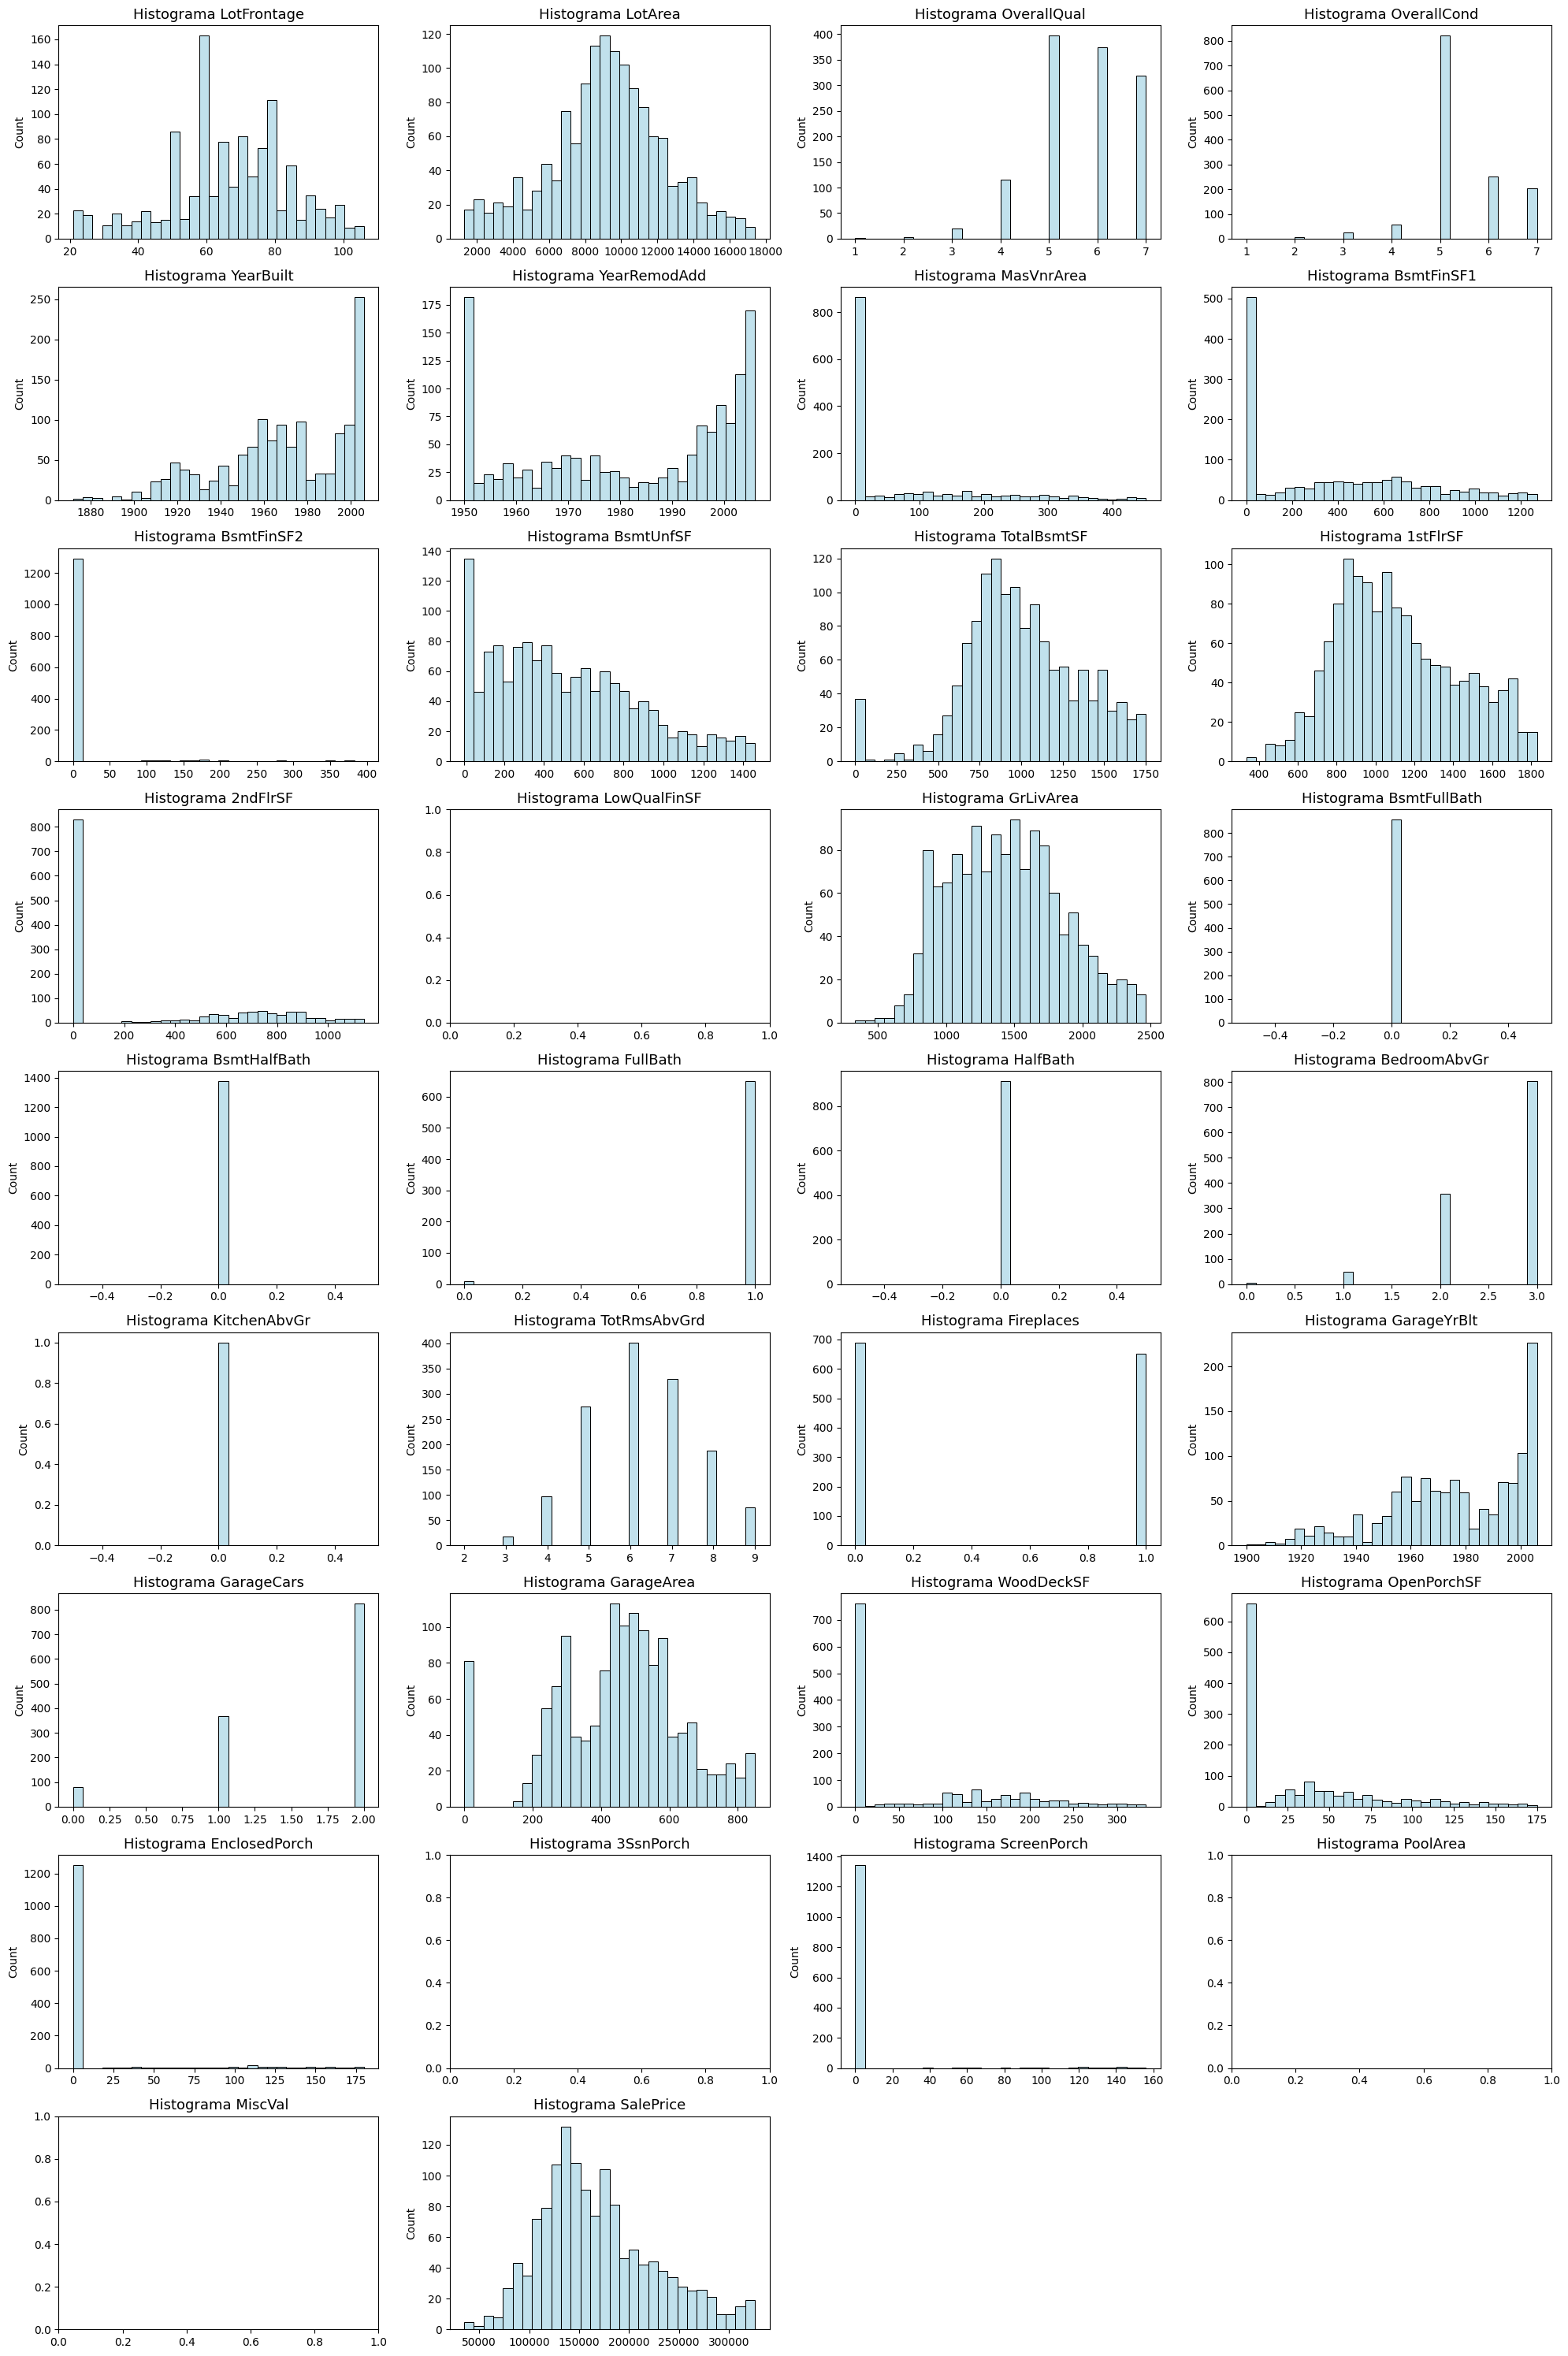

In [12]:
x = df.select_dtypes("number")

plt.figure(figsize=(20,30),dpi=100)
for i , n in enumerate(x.columns.to_list()):

    z = x[x[n] < x[n].quantile(0.95)][n]
    plt.subplot(9,4,i+1)
    ax = sns.histplot(x=z, kde=False, bins=30, color="lightblue", edgecolor="black" )#, multiple="stack")
    plt.title(f"Histograma {n}", fontdict={"fontsize":13})
    plt.xlabel("")
    plt.xticks(rotation=0)
    
plt.tight_layout();

**Realizamos aca scatterplot de nuestras variables continuas vs la variable objetivo**

-Se aprecia que algunas tienen una relacion lineal positiva fuerte con la variable objetivo.

Como por ejemplo:

- OverallQual (se entiende como una variable ordinal segun la descripcion).
- GrLivArea
- TotalBsmtSF



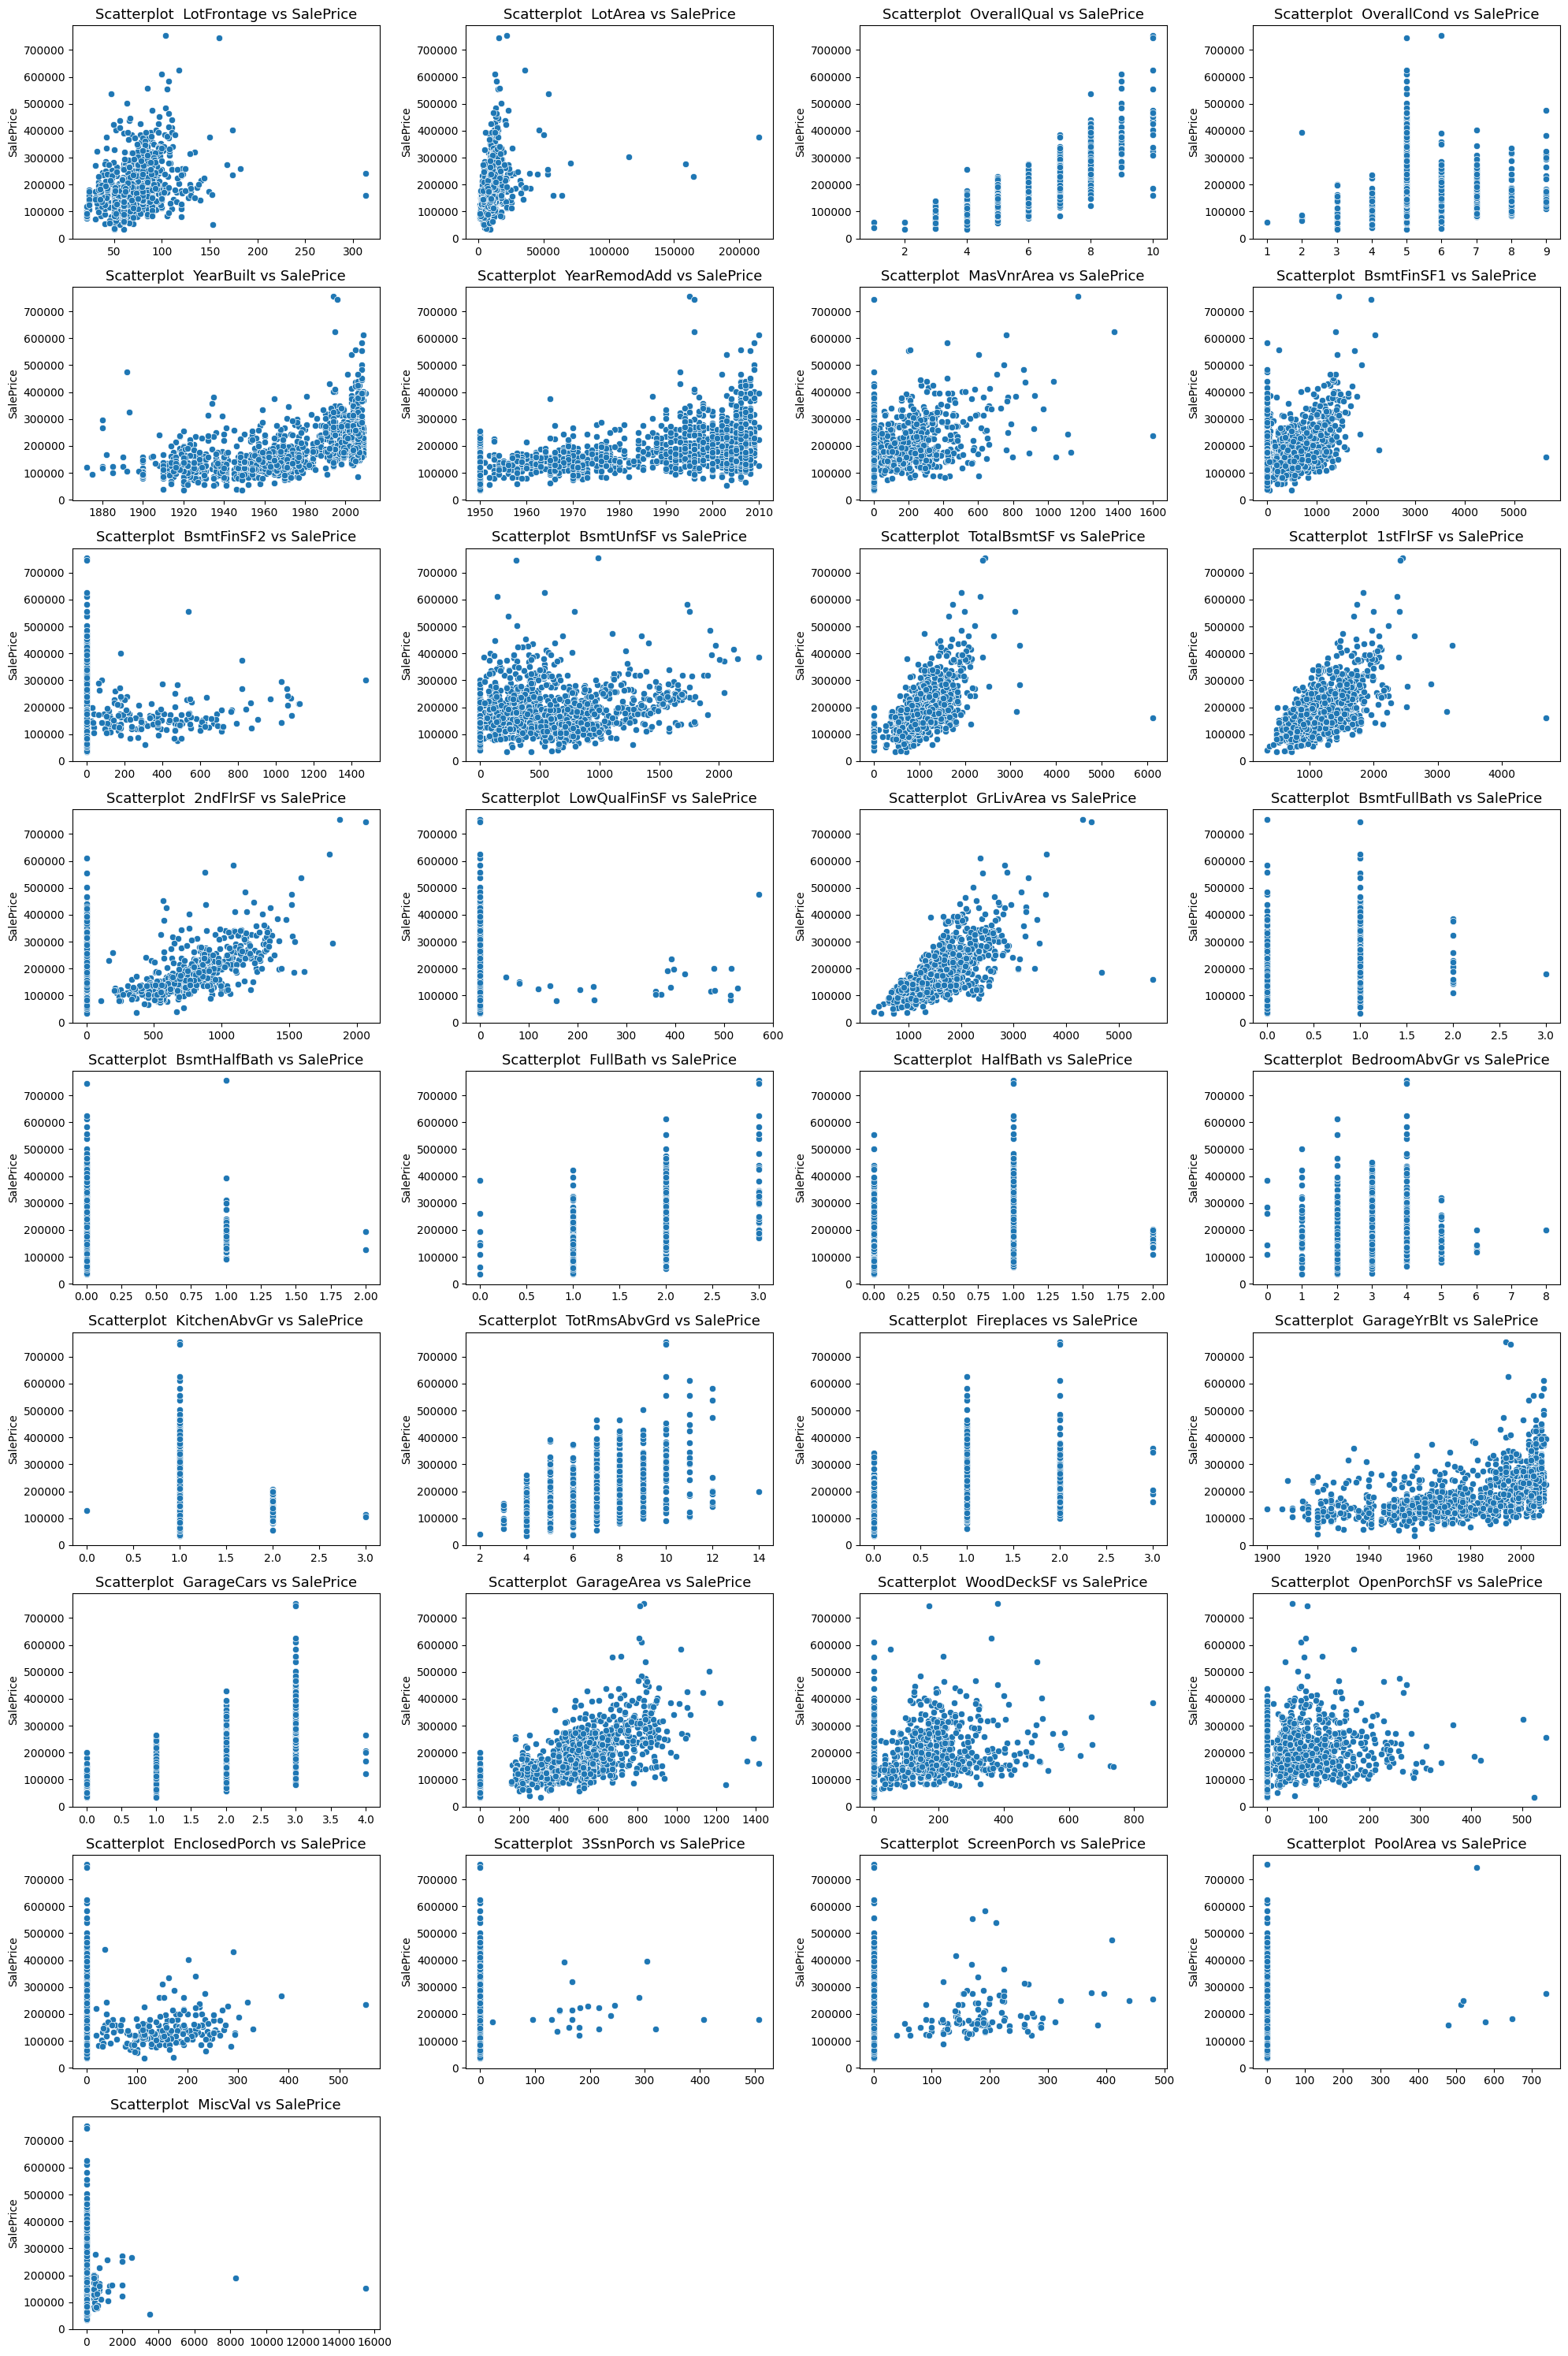

In [16]:
x = df.select_dtypes("number")
sale_price = x["SalePrice"]
x = x.drop("SalePrice",axis=1)

plt.figure(figsize=(20,30),dpi=100)
for i , n in enumerate(x.columns.to_list()):

    plt.subplot(9,4,i+1)
    ax = sns.scatterplot(x=x[n], y=sale_price) #color="lightblue", edgecolor="black" )#, multiple="stack")
    plt.title(f"Scatterplot {n} vs SalePrice", fontdict={"fontsize":13})
    plt.xlabel("")
    plt.xticks(rotation=0)
    
plt.tight_layout();

**Se observa que casi todas las variables continuas tienen outliers (valores atipicos) muy marcados hacia el extremo superior. 
Como ya se evidencio en los histogramas, en los boxplots tambien existen variables con distribuciones muy feas y no normales, que de seguro son candidatas a transformaciones de normalizacion.**

**Ya se menciono que apriori no tenemos planes de realizar normalizacion de features, tampoco trataremos los outliers.**

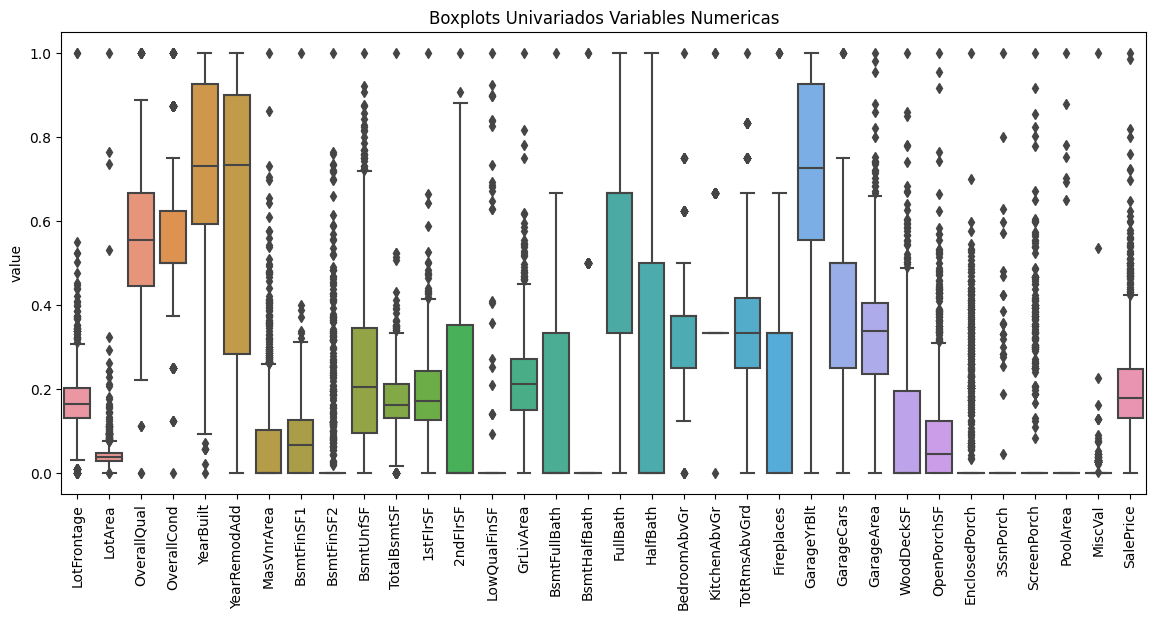

In [52]:
scaler = MinMaxScaler()
z = df.select_dtypes("number")
z = pd.DataFrame(scaler.fit_transform(z), columns=z.columns, index=z.index)
z = z.melt()

plt.figure(figsize=(14,6),dpi=100)
sns.boxplot(x=z["variable"], y=z["value"]);
plt.xticks(rotation=90);
plt.xlabel("");
plt.title("Boxplots Univariados Variables Numericas");

**A continuacion se realizara una especie de histograma de variables categoricas, agrupadas juntas en un heatmap para facilidad y rapidez de visualizacion/entendimiento, se necesitarian muchisimos countplots y/o pieplots para analizar todas las variables categoricas de este dataset, es por esto que estamos realizando este aproach, se excluyen variables categoricas que tienen mas de 8 categorias unicas porque distorcionarian el heatmap, como por ejemplo ("YearRemodAdd")**


**Observamos que hay varias sub-categorias que tienen muy pocos casos porcentualmente en relacion a la totalidad de la variable categorica a la que pertenecen, estas podrian ser candidatas a ser mezcladas con otras sub-categorias dentro de la misma variable, sin embargo tambien omitiremos simplificaciones de este tipo**

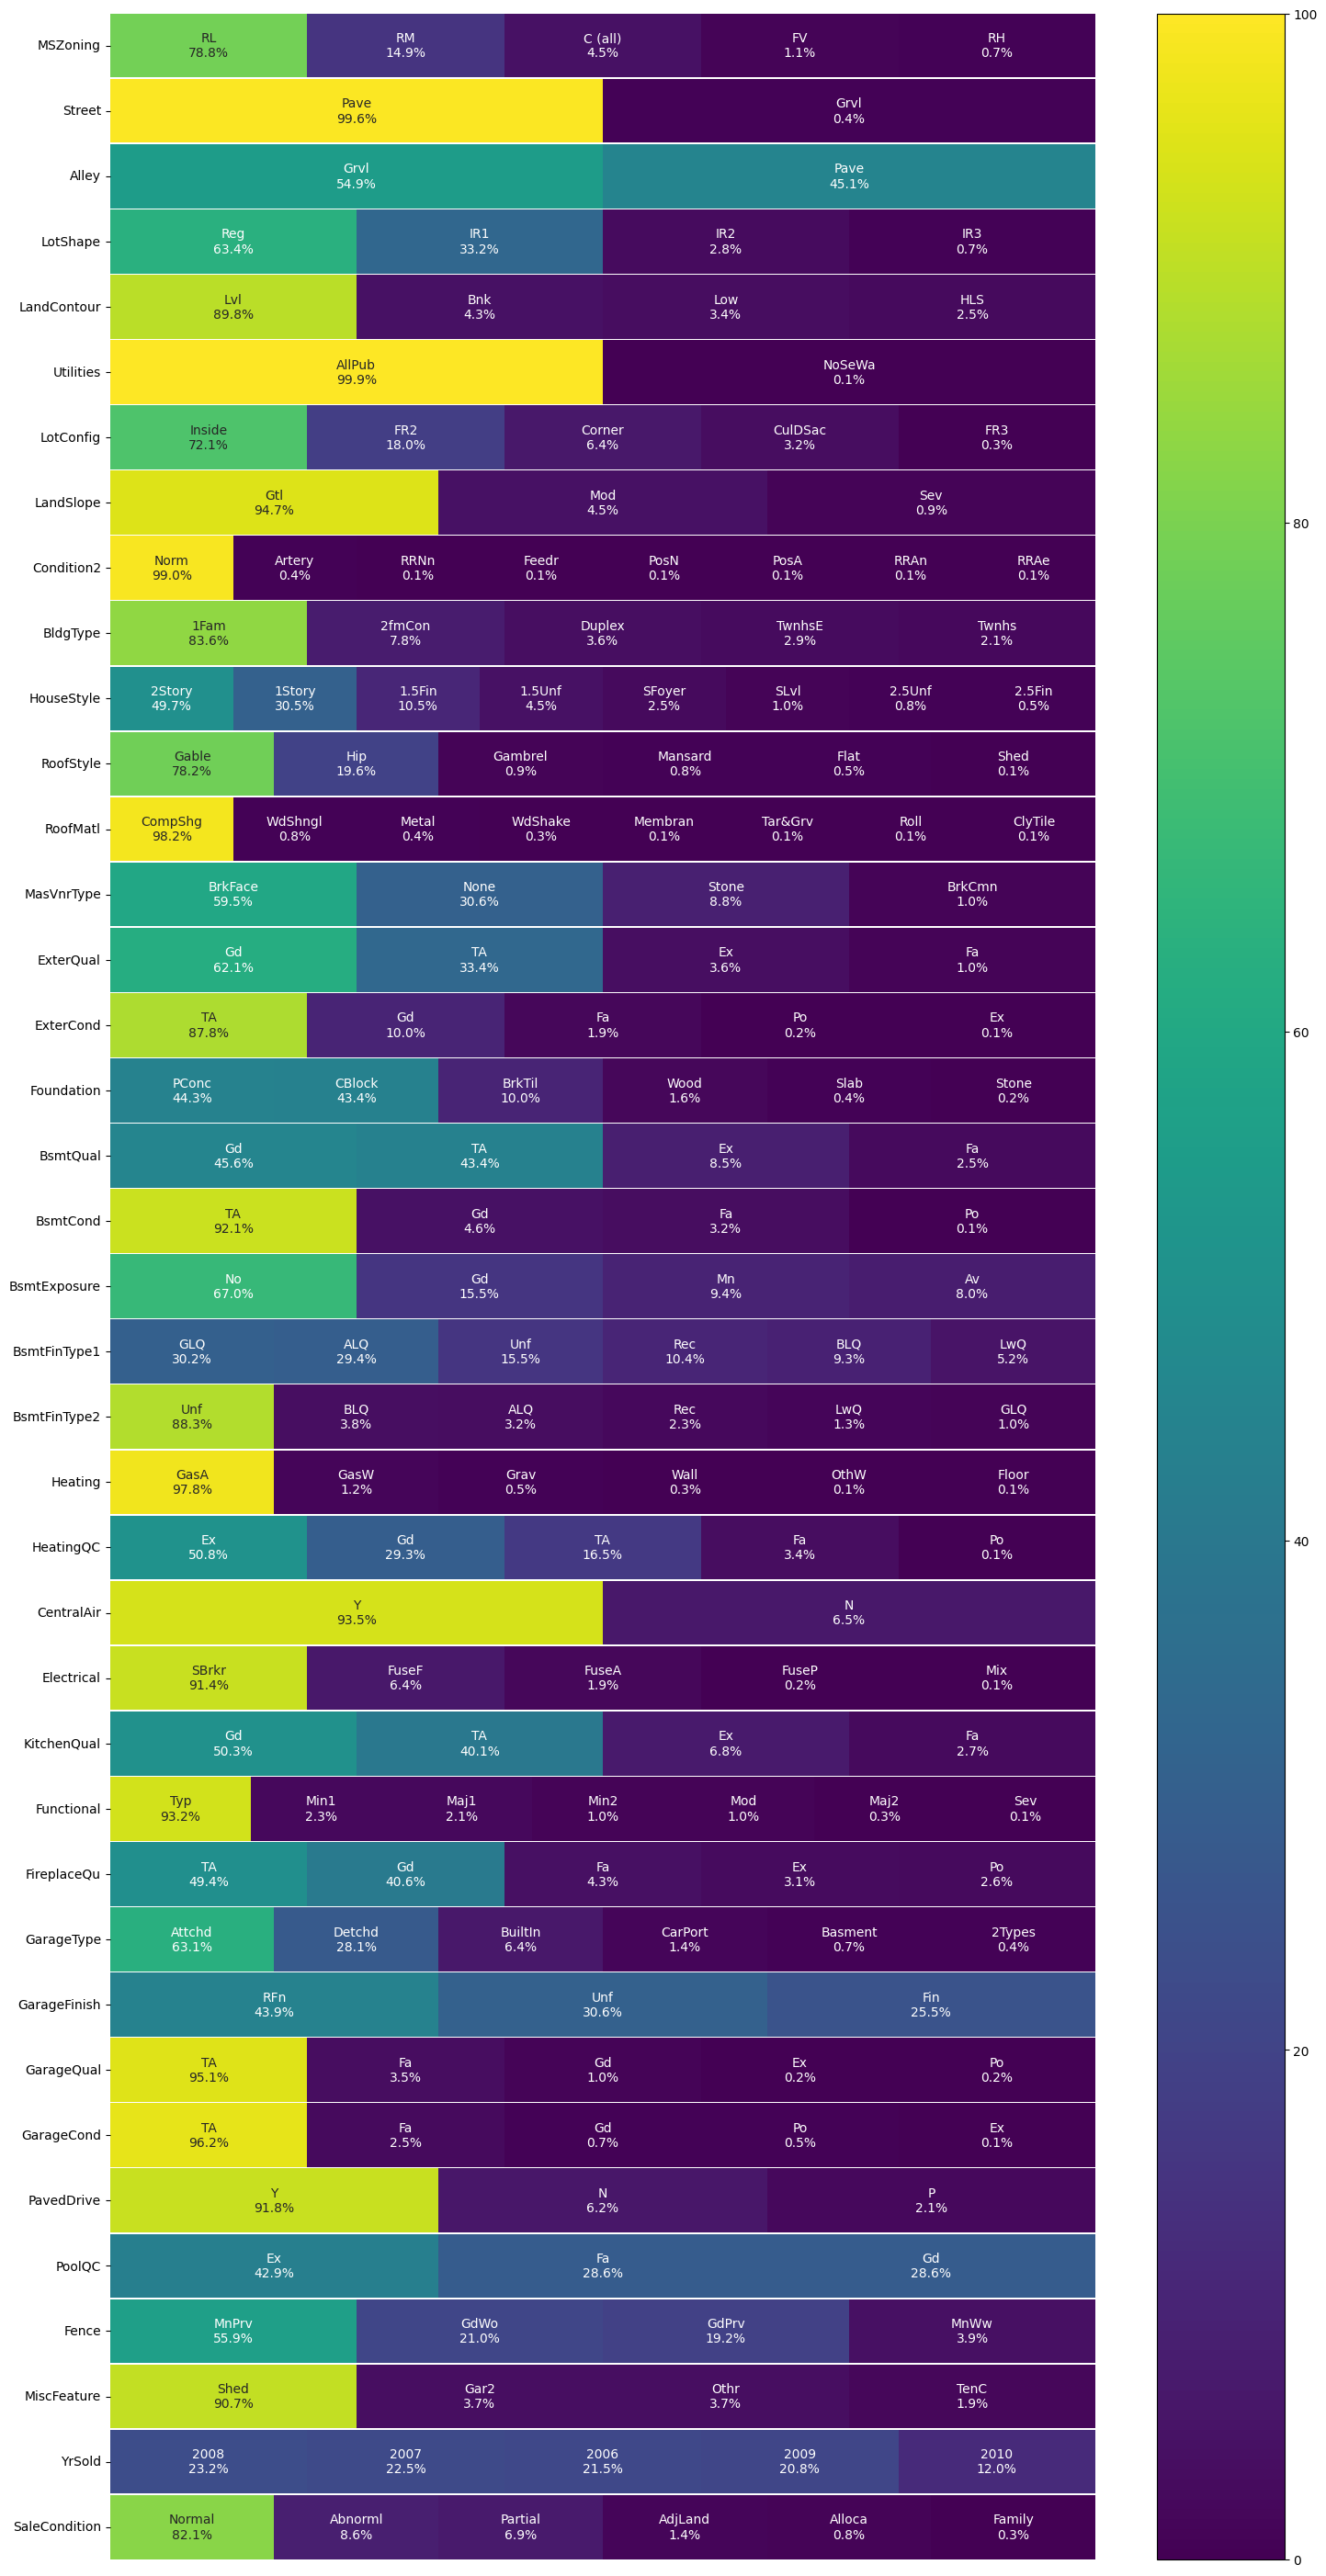

In [53]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def univariado_categorico(df, maximo = False, figsize = None, cmap="magma", rotacion = 90, numero = False):
    columnas = df.select_dtypes("object").columns
    columnas = columnas[df[columnas].nunique() < 9]
    figsize = (14, 1+.7*len(columnas)) if figsize is None else figsize
    fig, axes = plt.subplots(len(columnas), 1, figsize = figsize)
    plt.tight_layout(h_pad=-2)
    
    for ax, col in zip(axes, columnas):
        valores = df[col].value_counts()
        nombres = df[col].unique()
        nombres = nombres[~pd.isnull(nombres)]
        if numero == "total":
            nombres = nombres +"\n" +valores.astype(str)
        elif numero == "porcentaje":
            nombres = nombres +"\n"+np.round(100*valores/valores.sum(), 1).astype("str") +"%"
        sns.heatmap([valores], annot = [nombres], fmt = '', ax = ax, cbar = False, cmap = cmap, 
                    annot_kws={'rotation': rotacion}, vmin=0, vmax = None if maximo else df[col].value_counts().sum())
        ax.set_xticks([])
        ax.set_yticklabels([col], rotation = 0)
    
    if not maximo: fig.colorbar(ScalarMappable(Normalize(0, 100), cmap = cmap), ax = axes)

univariado_categorico(df, cmap = "viridis", numero = "porcentaje", rotacion=0)

**A continuacion realizare un barplot de correlacion Lineal entre las variables explicativas mas significativas (correlaciones mayores a 0.4 o menores a -0.4) con mi variable objetivo.**

In [54]:
df_corr_variable_objetivo = pd.get_dummies(df).corr()["SalePrice"].sort_values()[:-1]
df_corr_variable_objetivo = df_corr_variable_objetivo[(df_corr_variable_objetivo > 0.4) | (df_corr_variable_objetivo < -0.4)]

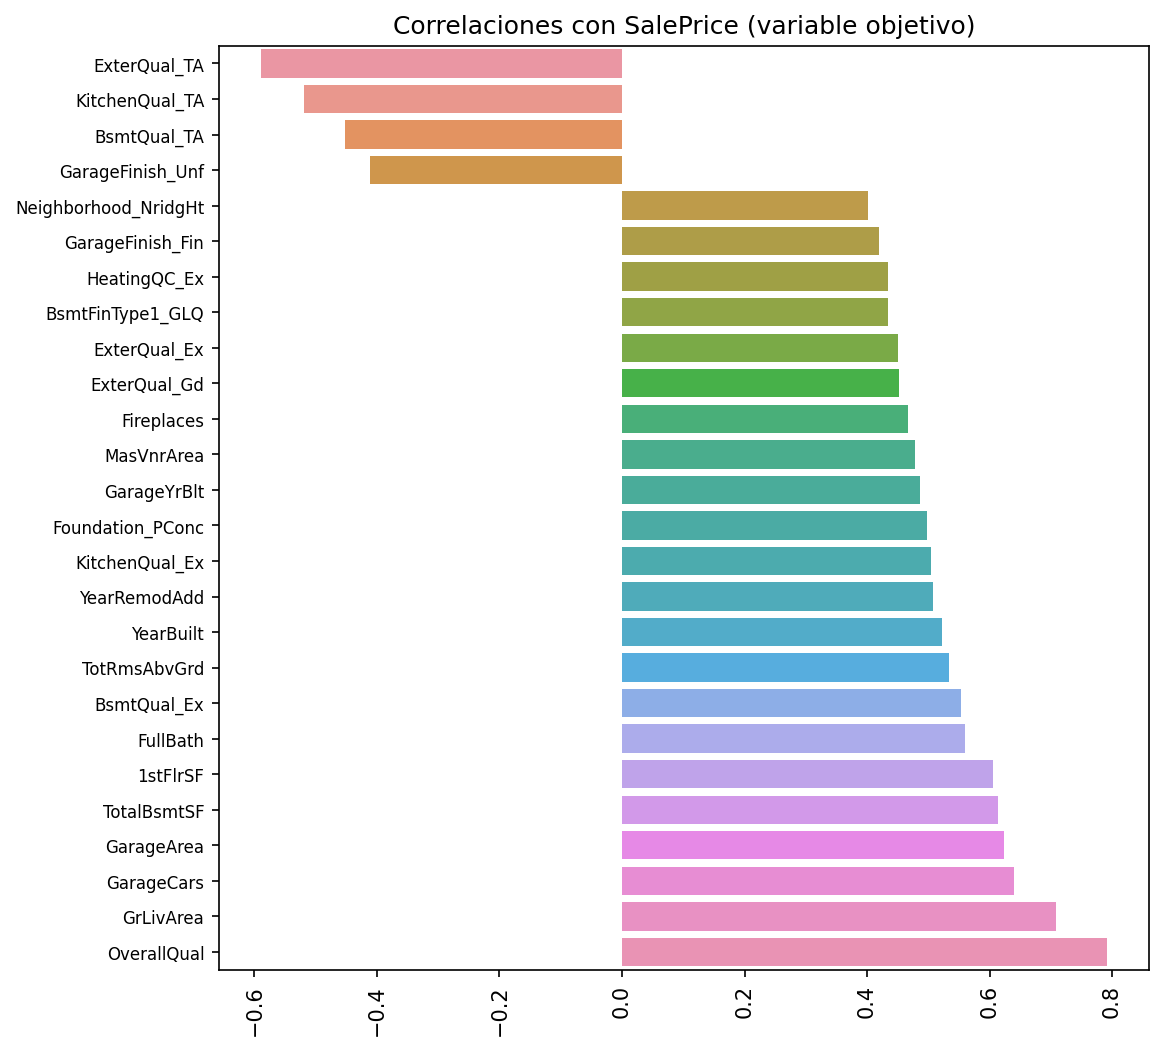

In [55]:
plt.figure(figsize=(8, 8), dpi=150)
sns.barplot(x=df_corr_variable_objetivo.values, y=df_corr_variable_objetivo.index, orient="h")
plt.title(label="Correlaciones con SalePrice (variable objetivo)")
plt.yticks(size=8)
plt.xticks(rotation=90);

Separo mi variable objetivo del resto del set de entramiento

In [56]:
y = df["SalePrice"]
X = df.drop("SalePrice",axis=1)
X_test = df_test

In [57]:
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,N

**Solucionando problemas de valores faltantes**

Documentacion de Pipelines de Preprocesamiento con pandas y scikitlearn

[link_1](https://queirozf.com/entries/scikit-learn-pipelines-custom-pipelines-and-pandas-integration)<br>
[link_2](https://towardsdatascience.com/creating-custom-transformers-for-sklearn-pipelines-d3d51852ecc1)

Voy a crear un pipeline de preprocesamiento para poder aplicar los siguientes criterios de relleno de valores perdidos tanto al train_set como al test_set, Lo estoy haciendo de esta forma porque quiero practicar y aprender a usar pipelines de preprocesamiento.

La gracia de los pipelines esque son muy utiles a la hora del model deployment, para hacer modificacion a nueva data entrante antes de alimentarla o evaluarla con un modelo.

Algunos criterios de feature engineneering se me occurieron mirando otros notebooks. (lo unico que he copiado).
Ya habia practicado con este dataset de antemano anterior al diplomado, es un dataset de kaggle bastante popular. En su momento mire varios notebooks por curiosidad.

In [58]:
# Defino la clase de mi transformador chulo personalizado a mis necesidades.

class DataframeFunctionTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, X, y=None, **transform_params):
        
        return self.func(self.full_df)

    def fit(self, train_df, new_data_df, **fit_params):
        
        self.full_df = pd.concat([train_df, new_data_df])
        return self

# Creo la Funcion de preprocesamiento para lidiar con valores faltantes y tambien de feature engineering.
def process_dataframe(full_df):
    
    # Elimino columnas con muchos valores perdidos y/o categoria muy predominante (ej: Utilities, Street).
    # "SalePrice" ya viene en precios actuales suprimiendo el factor inflacion, implica que MoSold, YrSold son inutiles.
    
    full_df = full_df.drop(['Utilities', 'Street', 'PoolQC', "Alley", "Fence", "MoSold", "YrSold"], axis=1)
    
    # La hoja de descripcion del dataset indica que NA se refiere a valores ("Typ") para la variable funcional.
    full_df['Functional'] = full_df['Functional'].fillna('Typ')

    # Se remplazan los valores faltantes continuos relacionados a garage con 0, ya que los valores nulos implican que no hay garage.
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        full_df[col] = full_df[col].fillna(0)
        
    # Se remplazan los valores faltantes categoricos relacionados a garage con "None", ya que los valores nulos implican que no hay garage.
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        full_df[col] = full_df[col].fillna('None')
        
    # Los valores nulos para estas variables categoricas de sotano, implican que no hay sotano.
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        full_df[col] = full_df[col].fillna('None')
        
    # Se remplazan los valores faltantes de las 6 columnas a continuacion con su moda.
    full_df['Electrical'] = full_df['Electrical'].fillna(full_df['KitchenQual'].mode()[0])
    full_df['KitchenQual'] = full_df['KitchenQual'].fillna(full_df['KitchenQual'].mode()[0])
    full_df['Exterior1st'] = full_df['Exterior1st'].fillna(full_df['Exterior1st'].mode()[0])
    full_df['Exterior2nd'] = full_df['Exterior2nd'].fillna(full_df['Exterior2nd'].mode()[0])
    full_df['SaleType'] = full_df['SaleType'].fillna(full_df['SaleType'].mode()[0])
    
    # Agrupo por subclase y lleno valores faltantes de zona en base a la moda de grupo de la subclase.
    full_df['MSZoning'] = full_df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    #Se agrupa por vecindarios, y se rellena los valores faltantes con la mediana de la distancia entre la casa/terreno (lot frontage)
    full_df['LotFrontage'] = full_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    
    
    # No se me ocurren otros criterios razonables para llenar los valores faltantes de las otras variables.
    # Usare el algoritmo de imputacion de valores perdidos "miceforest" para llenar valores faltantes
    
    cat_features = full_df.select_dtypes(exclude=np.number).columns.to_list()
    cat_idx = [full_df.columns.get_loc(col) for col in cat_features]

    for col in cat_features:
        full_df[col] = pd.Categorical(full_df[col])

    scheme_mmc_5 = mean_match_shap.copy()
    scheme_mmc_5.set_mean_match_candidates(5)
    
    kernel = mf.ImputationKernel(full_df, random_state=42, mean_match_scheme=scheme_mmc_5)
    kernel.mice(2, **{"device":"gpu", "min_data_in_leaf":10})
    full_df = kernel.complete_data()
        
        
    # Feature Engineering. (ideas de distintos notebooks antiguos que tengo y revise)
    
    full_df['BsmtFinType1_Unf'] = 1*(full_df['BsmtFinType1'] == 'Unf')
    full_df['HasWoodDeck'] = (full_df['WoodDeckSF'] == 0) * 1
    full_df['HasOpenPorch'] = (full_df['OpenPorchSF'] == 0) * 1
    full_df['HasEnclosedPorch'] = (full_df['EnclosedPorch'] == 0) * 1
    full_df['Has3SsnPorch'] = (full_df['3SsnPorch'] == 0) * 1
    full_df['HasScreenPorch'] = (full_df['ScreenPorch'] == 0) * 1
    full_df['Total_Home_Quality'] = full_df['OverallQual'] + full_df['OverallCond']
    full_df['TotalSF'] = full_df['TotalBsmtSF'] + full_df['1stFlrSF'] + full_df['2ndFlrSF']
    full_df['YrBltAndRemod'] = full_df['YearBuilt'] + full_df['YearRemodAdd']
    full_df['Total_sqr_footage'] = (full_df['BsmtFinSF1'] + full_df['BsmtFinSF2'] + full_df['1stFlrSF'] + full_df['2ndFlrSF'])
    full_df['Total_Bathrooms'] = (full_df['FullBath'] + (0.5 * full_df['HalfBath']) + full_df['BsmtFullBath'] + (0.5 * full_df['BsmtHalfBath']))
    full_df['Total_porch_sf'] = (full_df['OpenPorchSF'] + full_df['3SsnPorch'] + full_df['EnclosedPorch'] + full_df['ScreenPorch'] + full_df['WoodDeckSF'])
        
    # Creo variables categoricas en base a variables continuas    
    full_df['GarageCars'] = full_df['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
    full_df['haspool'] = full_df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    full_df['has2ndfloor'] = full_df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    full_df['hasgarage'] = full_df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    full_df['hasbsmt'] = full_df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    full_df['hasfireplace'] = full_df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
    return full_df

In [59]:
from sklearn.pipeline import make_pipeline, Pipeline
pipeline = Pipeline([
    ("preprocesamiento_feature_engineering", DataframeFunctionTransformer(process_dataframe))
])

full_df = pipeline.fit_transform(X, X_test)

C:\Users\56976\anaconda3\envs\TimeSeriesDarts\lib\site-packages\miceforest\ImputationKernel.py:369: UserWarning: [MSSubClass,Condition2,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterCond,Foundation,BsmtCond,Heating,HeatingQC,Electrical,Functional,GarageQual,GarageCond,SaleType] have very rare categories, it is a good idea to group these, or set the min_data_in_leaf parameter to preventlightgbm from outputting 0.0 probabilities.
  warn(


In [60]:
# Paso data numerica a float32 para que compute mas rapido.

full_df[full_df.select_dtypes("number").columns.to_list()] = full_df[full_df.select_dtypes("number").columns.to_list()].astype("float32")

**Vemos que ya no hay valores faltantes.**

In [61]:
full_df.isnull().sum().sort_values(ascending=False)

MSSubClass            0
YrBltAndRemod         0
BsmtFinSF2_log        0
BsmtFinSF1_log        0
MasVnrArea_log        0
                     ..
CentralAir            0
HeatingQC             0
Heating               0
TotalBsmtSF           0
GarageArea_log_**2    0
Length: 127, dtype: int64

**debo separar el full_df creado en sus partes de entrenamiento y testeo, estos fueron unidos para poder aplicarles el pipeline de preprocesamiento, ahora los separo.**

In [62]:
X = full_df.iloc[:len(df), :]
X_test_final = full_df.iloc[len(df):, :]

y_test no existe, es lo que quiero predecir.

In [63]:
X.shape, y.shape , X_test_final.shape

((1460, 127), (1460,), (1459, 127))

**Aqui observamos que posterior al preprocesado y feature engineering, algunas variables creadas que fueron agregadas tienen una correlacion relativamente fuerte con nuestra variable objetivo.**

**Posiblemente tambien tengamos varias variables explicativas que estan correlacionadas entre si, tendriamos problemas con esto si quizas usaramos modelos como regresion lineal o naive bayes, pero los modelos de arboles tambien son robustos cuando se enfretan a variables explicativas fuertemente correlaciondas entre si (impacta en la interpretacion del modelo pero no en la capacidad predictiva de este).**

In [64]:
df_limpiado = X.copy()
df_limpiado["SalePrice"] = y.copy()


df_corr_variable_objetivo = pd.get_dummies(df_limpiado).corr()["SalePrice"].sort_values()[:-1]
df_corr_variable_objetivo = df_corr_variable_objetivo[(df_corr_variable_objetivo > 0.4) | (df_corr_variable_objetivo < -0.4)].sort_values()[:-1]

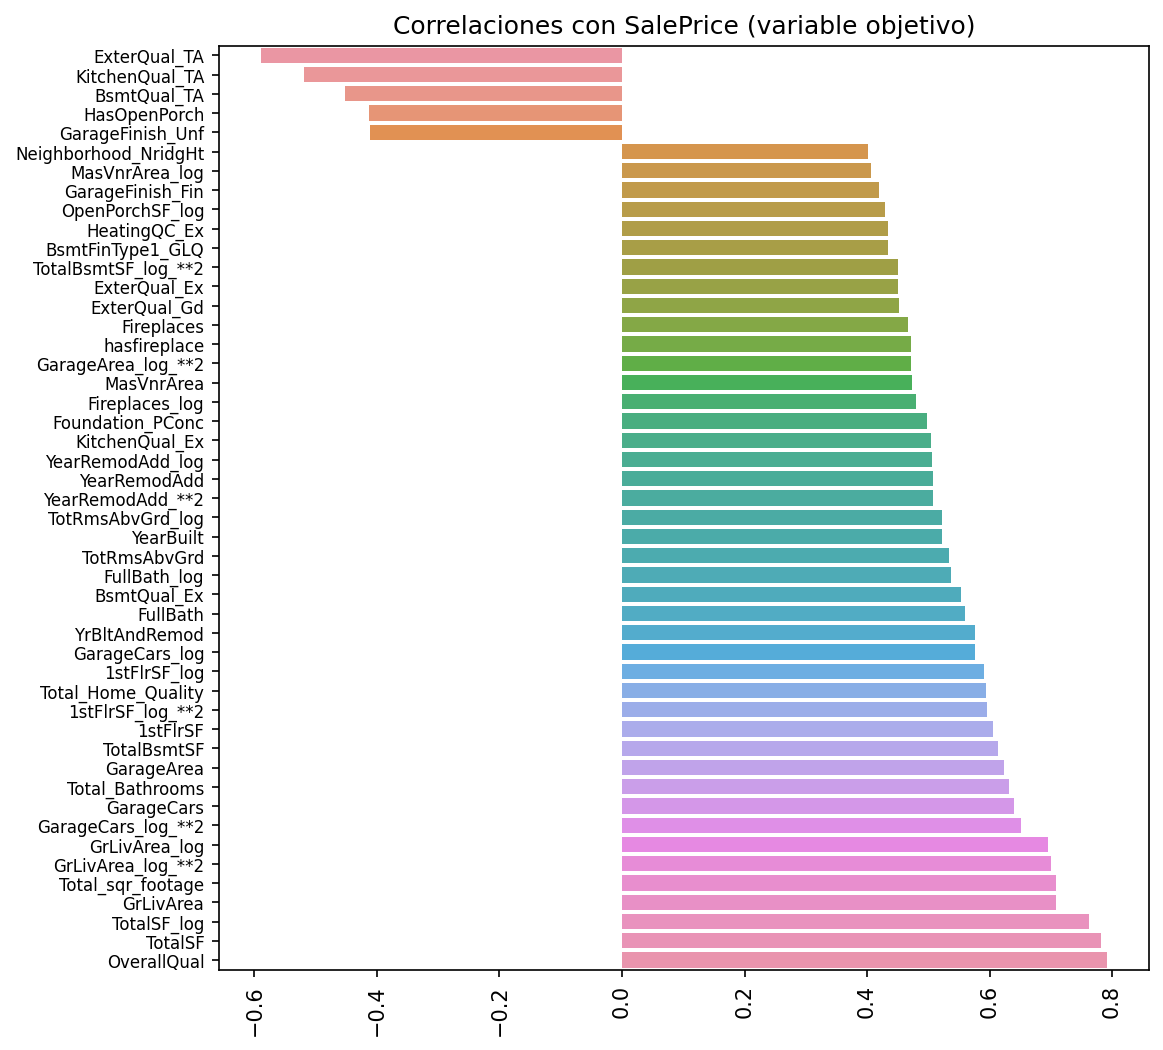

In [65]:
plt.figure(figsize=(8, 8), dpi=150)
sns.barplot(x=df_corr_variable_objetivo.values, y=df_corr_variable_objetivo.index, orient="h")
plt.title(label="Correlaciones con SalePrice (variable objetivo)")
plt.yticks(size=8)
plt.xticks(rotation=90);

# Modelos

Probare con 2 modelos de gradient boosting LightGBM y XGBOOST, me enfocare solo en la capacidad predictiva de estos, me da igual su interpretabilidad ya que no es el objetivo de la competencia y tampoco fue solicitado por el profesor en el enunciado.

### LightGBM

LIGHTGBM soporta variables categoricas, estoy utilizando optuna que implementa una busqueda bayesiana de hyperparametros (es mejor que usar GridSearch o RandomizedSearchCV de scikit-learn en mi opinion), incluye pruning para agilizar el proceso y lightGBM corre con la GPU.

- No necesito escalar la data cuando uso arboles de decisiones.
- Voy a utilizar un crossvalidation de 10 kfold.

In [66]:
# Necesito indicarle a LightGBM que features son categoricos, pasandolos a ese respectivo datatype especifico.


cat_features = X.select_dtypes(exclude=np.number).columns.to_list()
cat_idx = [X.columns.get_loc(col) for col in cat_features]

for col in cat_features:
    X[col] = pd.Categorical(X[col])

C:\Users\56976\AppData\Local\Temp\ipykernel_18336\2870482661.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.Categorical(X[col])


In [259]:
from lightgbm import LGBMRegressor
import warnings
import optuna

params = LGBMRegressor().get_params()
print(params)


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [73]:
# class hacer_nada():
#     def __init__(self):
#         pass

#     def transform(self, input_df, **transform_params):
#         return input_df

#     def fit(self, X, y=None, **fit_params):
#         return self
    
# cat_col = X_train.select_dtypes("category").columns.to_list()
# num_col = X_train.select_dtypes("number").columns.to_list()


# scaler = RobustScaler()
# encoder = hacer_nada()

# num_transformer = make_pipeline(scaler)
# cat_transformer = make_pipeline(encoder)


# preprocessor = ColumnTransformer(
#       transformers=[('num', num_transformer, num_col),
#                     ('cat', cat_transformer, cat_col)])

In [261]:
warnings.filterwarnings("ignore")
from optuna.integration import LightGBMPruningCallback
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import  mean_squared_error
from optuna.samplers import TPESampler
from sklearn.compose import ColumnTransformer
def objective(trial, X, y):


    
    param_grid = {
        "random_state": 123,
        "verbosity": -1,
        "boosting_type": trial.suggest_categorical("boosting_type", ['gbdt']),#,"goss"]),
        "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 3050,step=100), #for large datasets this should be very high
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 10, 190, step=20), # Also change this for large datasets, should be small to avoid overfitting
        "max_depth": trial.suggest_int("max_depth", 2, 80),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 800, step=20), #modify this for large datasets, causes overfittin if too low
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0001, 100, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0001, 100, log=True),
        #"min_split_gain": trial.suggest_float("min_split_gain", 0, 3),
        "subsample": trial.suggest_float("subsample", 0.3, 1, step=0.1),
        "subsample_freq": trial.suggest_categorical("subsample_freq", [0,1]), #[0,1] bagging
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1, step=0.1),
    }
    
    #min_data_in_leaf # min_child_samples
    
# Aqui defino funcion a minimizar, usar el RMSLE (Root Mean Squared Log Error), ya que esta es la metrica de evaluacion de la competencia.
    def rmse(y_val,y_pred):
        is_higher_better = False
        name = "rmse"
        value = mean_squared_error(np.log(y_val),np.log(y_pred), squared=False)
        return name, value, is_higher_better
                                   
    cv = KFold(n_splits=10, shuffle=True, random_state=12)

    cv_scores = np.empty(10)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y[train_idx], y[test_idx]
        
        #scaler = RobustScaler()
        #X_train[X_train.select_dtypes("number").columns.to_list()] = scaler.fit_transform(X_train[X_train.select_dtypes("number").columns.to_list()])
        #X_val[X_val.select_dtypes("number").columns.to_list()] = scaler.transform(X_val[X_val.select_dtypes("number").columns.to_list()])

        model = LGBMRegressor(objective="regression", silent=True,**param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            eval_metric=rmse,
            early_stopping_rounds=100,
            categorical_feature="auto",   # cat_idx, #specifiy categorial features.
            callbacks=[LightGBMPruningCallback(trial, "rmse", report_interval=10)],  # Add a pruning callback
            verbose=0)
        
        preds =  model.predict(X_val)
        
        cv_scores[idx] = mean_squared_error(np.log(y_val),np.log(preds), squared=False)

    
    return np.mean(cv_scores)

In [262]:
study = optuna.create_study(direction="minimize", study_name="LGBM Regressor",sampler=TPESampler(),
                            pruner=optuna.pruners.PercentilePruner(30, n_startup_trials=5, n_warmup_steps=50))
#study.enqueue_trial(try_this_first)
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=200)

[I 2022-12-05 23:38:02,067] A new study created in memory with name: LGBM Regressor
[I 2022-12-05 23:38:07,326] Trial 0 finished with value: 0.40670004025521933 and parameters: {'boosting_type': 'gbdt', 'device_type': 'gpu', 'n_estimators': 1050, 'learning_rate': 0.07194569092508385, 'num_leaves': 170, 'max_depth': 41, 'min_child_samples': 790, 'reg_alpha': 0.0007563079674295933, 'reg_lambda': 12.207166176232722, 'subsample': 0.3, 'subsample_freq': 1, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.40670004025521933.
[I 2022-12-05 23:38:12,998] Trial 1 finished with value: 0.1478908891782079 and parameters: {'boosting_type': 'gbdt', 'device_type': 'gpu', 'n_estimators': 550, 'learning_rate': 0.2721008021066094, 'num_leaves': 130, 'max_depth': 15, 'min_child_samples': 310, 'reg_alpha': 0.09293790516442782, 'reg_lambda': 0.0001800130808501696, 'subsample': 1.0, 'subsample_freq': 1, 'colsample_bytree': 0.8}. Best is trial 1 with value: 0.1478908891782079.
[I 2022-12-05 23:38:25,32

[I 2022-12-05 23:39:10,373] Trial 47 pruned. Trial was pruned at iteration 229.
[I 2022-12-05 23:39:16,203] Trial 48 finished with value: 0.13116032739809444 and parameters: {'boosting_type': 'gbdt', 'device_type': 'gpu', 'n_estimators': 2750, 'learning_rate': 0.28491642764170927, 'num_leaves': 150, 'max_depth': 68, 'min_child_samples': 90, 'reg_alpha': 21.8352075092004, 'reg_lambda': 0.1894313000425286, 'subsample': 0.5, 'subsample_freq': 0, 'colsample_bytree': 0.6000000000000001}. Best is trial 48 with value: 0.13116032739809444.
[I 2022-12-05 23:39:16,540] Trial 49 pruned. Trial was pruned at iteration 109.
[I 2022-12-05 23:39:16,919] Trial 50 pruned. Trial was pruned at iteration 89.
[I 2022-12-05 23:39:17,592] Trial 51 pruned. Trial was pruned at iteration 119.
[I 2022-12-05 23:39:18,006] Trial 52 pruned. Trial was pruned at iteration 89.
[I 2022-12-05 23:39:19,655] Trial 53 pruned. Trial was pruned at iteration 229.
[I 2022-12-05 23:39:19,928] Trial 54 pruned. Trial was pruned at

[I 2022-12-05 23:41:16,077] Trial 83 finished with value: 0.12625263144317894 and parameters: {'boosting_type': 'gbdt', 'device_type': 'gpu', 'n_estimators': 150, 'learning_rate': 0.13155941600345047, 'num_leaves': 190, 'max_depth': 75, 'min_child_samples': 50, 'reg_alpha': 10.027189895485492, 'reg_lambda': 12.146275899962887, 'subsample': 0.8, 'subsample_freq': 0, 'colsample_bytree': 0.3}. Best is trial 83 with value: 0.12625263144317894.
[I 2022-12-05 23:41:25,981] Trial 84 finished with value: 0.1251792154393973 and parameters: {'boosting_type': 'gbdt', 'device_type': 'gpu', 'n_estimators': 150, 'learning_rate': 0.10918715860405753, 'num_leaves': 190, 'max_depth': 75, 'min_child_samples': 30, 'reg_alpha': 9.246521949587827, 'reg_lambda': 11.645867934631928, 'subsample': 0.8, 'subsample_freq': 0, 'colsample_bytree': 0.3}. Best is trial 84 with value: 0.1251792154393973.
[I 2022-12-05 23:41:35,922] Trial 85 finished with value: 0.12432508093143199 and parameters: {'boosting_type': 'gb

[I 2022-12-05 23:42:43,115] Trial 120 finished with value: 0.1267626771858293 and parameters: {'boosting_type': 'gbdt', 'device_type': 'gpu', 'n_estimators': 50, 'learning_rate': 0.1327537990321205, 'num_leaves': 170, 'max_depth': 47, 'min_child_samples': 30, 'reg_alpha': 1.6367671511329724, 'reg_lambda': 1.0015752860643417, 'subsample': 0.9000000000000001, 'subsample_freq': 0, 'colsample_bytree': 0.4}. Best is trial 85 with value: 0.12432508093143199.
[I 2022-12-05 23:42:47,186] Trial 121 finished with value: 0.13062357634289773 and parameters: {'boosting_type': 'gbdt', 'device_type': 'gpu', 'n_estimators': 50, 'learning_rate': 0.12992103498634575, 'num_leaves': 170, 'max_depth': 48, 'min_child_samples': 30, 'reg_alpha': 1.726906840017108, 'reg_lambda': 17.801500925634187, 'subsample': 0.9000000000000001, 'subsample_freq': 0, 'colsample_bytree': 0.4}. Best is trial 85 with value: 0.12432508093143199.
[I 2022-12-05 23:42:47,627] Trial 122 pruned. Trial was pruned at iteration 79.
[I 20

[I 2022-12-05 23:44:39,840] Trial 153 finished with value: 0.1288142437678395 and parameters: {'boosting_type': 'gbdt', 'device_type': 'gpu', 'n_estimators': 50, 'learning_rate': 0.09625510951808046, 'num_leaves': 190, 'max_depth': 61, 'min_child_samples': 50, 'reg_alpha': 13.88451023602269, 'reg_lambda': 0.32580423119524743, 'subsample': 0.9000000000000001, 'subsample_freq': 0, 'colsample_bytree': 0.3}. Best is trial 140 with value: 0.12422371057124496.
[I 2022-12-05 23:44:44,356] Trial 154 finished with value: 0.1266490461078568 and parameters: {'boosting_type': 'gbdt', 'device_type': 'gpu', 'n_estimators': 50, 'learning_rate': 0.09394663323487848, 'num_leaves': 190, 'max_depth': 65, 'min_child_samples': 30, 'reg_alpha': 8.936960573108674, 'reg_lambda': 0.8965515926458576, 'subsample': 0.9000000000000001, 'subsample_freq': 0, 'colsample_bytree': 0.3}. Best is trial 140 with value: 0.12422371057124496.
[I 2022-12-05 23:44:48,889] Trial 155 finished with value: 0.1396229946278137 and p

[I 2022-12-05 23:46:15,163] Trial 181 pruned. Trial was pruned at iteration 59.
[I 2022-12-05 23:46:23,424] Trial 182 finished with value: 0.12989852090771686 and parameters: {'boosting_type': 'gbdt', 'device_type': 'gpu', 'n_estimators': 50, 'learning_rate': 0.10846008536434748, 'num_leaves': 190, 'max_depth': 74, 'min_child_samples': 10, 'reg_alpha': 13.02783742232244, 'reg_lambda': 1.5900160677179587, 'subsample': 0.9000000000000001, 'subsample_freq': 1, 'colsample_bytree': 0.3}. Best is trial 140 with value: 0.12422371057124496.
[I 2022-12-05 23:46:23,823] Trial 183 pruned. Trial was pruned at iteration 59.
[I 2022-12-05 23:46:28,422] Trial 184 finished with value: 0.12767305308938923 and parameters: {'boosting_type': 'gbdt', 'device_type': 'gpu', 'n_estimators': 50, 'learning_rate': 0.10235381994203334, 'num_leaves': 190, 'max_depth': 60, 'min_child_samples': 30, 'reg_alpha': 10.833508380546618, 'reg_lambda': 0.9619157667025844, 'subsample': 0.9000000000000001, 'subsample_freq': 0

In [263]:
params = study.best_params

In [264]:
model = LGBMRegressor(objective="regression",random_state=123,**params)
model.fit(X, y)

LGBMRegressor(colsample_bytree=0.3, device_type='gpu',
              learning_rate=0.1085618442769923, max_depth=63,
              min_child_samples=30, n_estimators=150, num_leaves=190,
              objective='regression', random_state=123,
              reg_alpha=9.083639341361899, reg_lambda=1.7440550494047653)

In [265]:
cat_features = X_test_final.select_dtypes(exclude=np.number).columns.to_list()
cat_idx = [X_test_final.columns.get_loc(col) for col in cat_features]

for col in cat_features:
    X_test_final[col] = pd.Categorical(X_test_final[col])


X_test_final

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscFeature,MiscVal,SaleType,SaleCondition,BsmtFinType1_Unf,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch,Total_Home_Quality,TotalSF,YrBltAndRemod,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
0,20,RH,80.0,11622.0,Reg,Lvl,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5.0,6.0,1961.0,1961.0,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896.0,0.0,0.0,896.0,0.0,0.0,1.0,0.0,2.0,1.0,TA,5.0,Typ,0.0,TA,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140.0,0.0,0.0,0.0,120.0,0.0,Shed,0.0,WD,Normal,0.0,0.0,1.0,1.0,1.0,0.0,11.0,1778.0,3922.0,1508.0,1.0,260.0,0.0,0.0,1.0,1.0,0.0
1,20,RL,81.0,14267.0,IR1,Lvl,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6.0,6.0,1958.0,1958.0,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329.0,0.0,0.0,1329.0,0.0,0.0,1.0,1.0,3.0,1.0,Gd,6.0,Typ,0.0,TA,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393.0,36.0,0.0,0.0,0.0,0.0,Gar2,12500.0,WD,Normal,0.0,0.0,0.0,1.0,1.0,1.0,12.0,2658.0,3916.0,2252.0,1.5,429.0,0.0,0.0,1.0,1.0,0.0
2,60,RL,74.0,13830.0,IR1,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5.0,5.0,1997.0,1998.0,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928.0,701.0,0.0,1629.0,0.0,0.0,2.0,1.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212.0,34.0,0.0,0.0,0.0,0.0,Shed,0.0,WD,Normal,0.0,0.0,0.0,1.0,1.0,1.0,10.0,2557.0,3995.0,2420.0,2.5,246.0,0.0,1.0,1.0,1.0,1.0
3,60,RL,78.0,9978.0,IR1,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6.0,6.0,1998.0,1998.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926.0,678.0,0.0,1604.0,0.0,0.0,2.0,1.0,3.0,1.0,Gd,7.0,Typ,1.0,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360.0,36.0,0.0,0.0,0.0,0.0,Shed,0.0,WD,Normal,0.0,0.0,0.0,1.0,1.0,1.0,12.0,2530.0,3996.0,2206.0,2.5,396.0,0.0,1.0,1.0,1.0,1.0
4,120,RL,43.0,5005.0,IR1,HLS,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8.0,5.0,1992.0,1992.0,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280.0,0.0,0.0,1280.0,0.0,0.0,2.0,0.0,2.0,1.0,Gd,5.0,Typ,0.0,TA,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0.0,82.0,0.0,0.0,144.0,0.0,Shed,0.0,WD,Normal,0.0,1.0,0.0,1.0,1.0,0.0,13.0,2560.0,3984.0,1543.0,2.0,226.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936.0,Reg,Lvl,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4.0,7.0,1970.0,1970.0,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546.0,546.0,0.0,1092.0,0.0,0.0,1.0,1.0,3.0,1.0,TA,5.0,Typ,0.0,TA,None,0.0,None,0.0,0.0,None,None,Y,0.0,0.0,0.0,0.0,0.0,0.0,Shed,0.0,WD,Normal,1.0,1.0,1.0,1.0,1.0,1.0,11.0,1638.0,3940.0,1092.0,1.5,0.0,0.0,1.0,0.0,1.0,0.0
1455,160,RM,21.0,1894.0,Reg,Lvl,Inside,Gtl,MeadowV,Norm,Norm,

In [266]:
preds = model.predict(X_test_final)

In [168]:
submission_df = pd.DataFrame([test_id,preds]).transpose()

In [169]:
submission_df

,Id,Unnamed 0
0,1461.0,123457.237167
1,1462.0,164913.492933
2,1463.0,184160.712614
3,1464.0,194391.952656
4,1465.0,191783.372606
...,...,...
1454,2915.0,82287.781621
1455,2916.0,85700.582387
1456,2917.0,159025.945383
1457,2918.0,117184.160683


Dejo bonito el df_submission para que no joda Kaggle.

In [170]:
submission_df = submission_df.rename(columns={"Unnamed 0":"SalePrice"})
submission_df["Id"] = submission_df["Id"].astype("int64")
submission_df.head()

,Id,SalePrice
0,1461,123457.237167
1,1462,164913.492933
2,1463,184160.712614
3,1464,194391.952656
4,1465,191783.372606


In [171]:
submission_df.to_csv("submission_lightgbm.csv", index=False)

## XGBOOST

Xgboost no soporta variables categoricas de momento, trate usando el argumento enable_categorical=True, pero no funcionaba, la documentacion dice que todavia es experimental, por eso a diferencia de LightGBM aca tuve que pasar las variables categoricas a dummies antes de correr el algoritmo, volvi a usar optuna para la busqueda de hyperparametros.

Xgboost me dio un desempeño ligeramente mejor que LightGBM en terminos de RMSLE. segun lo que me arrojo optuna cuando busco los hyperparametros optimos. Por eso este es mi modelo de eleccion final para hacer el Submission.

El mejor resultado me daba 0.1225 RMSLE, (no se aprecia mas abajo, limpie el output de la celda sin querer donde se corrio optuna y el modelo), (Me da flojera volverlo a correr).

Despues de hacer la submission el resultado que me devolvio Kaggle fue de 0.1237. Lo cual es un resultado satisfactorio que implica que mi modelo no hizo overfitting.

In [69]:
X_xgboost = pd.get_dummies(X.copy())
X_xgboost =  X_xgboost.loc[:,~X_xgboost.columns.duplicated()] # Elimino columnas que tienen nombre duplicado
                                                                # Problema que surgio al hacer pd.getdummies()

In [70]:
warnings.filterwarnings("default")

import optuna
from xgboost import XGBRegressor
import xgboost
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def objective(trial, X, y):

    param = {
        'verbosity' : 0,
        #"enable_categorical": True,
        "random_state": 123,
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1, step=0.1),
        "subsample": trial.suggest_float("subsample", 0.3, 1, step=0.1),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 1),
        "n_estimators": trial.suggest_int("n_estimators", 50, 2950,step=100), #For big dataset i should try high number.
        "max_depth": trial.suggest_int("max_depth", 2, len(X.columns)),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
        "early_stopping_rounds":100,
        "eval_metric": "rmse"
    }

    
    cv = KFold(n_splits=10, shuffle=True, random_state=12)
    #y = y.values
    cv_scores = []
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y[train_idx], y[test_idx]
        
        model1 = XGBRegressor(objective="reg:squarederror",**param)
    
        
        model1.fit(X_train,y_train, eval_set=[(X_val,y_val)],verbose=0)
        
        preds =  model1.predict(X_val)
        
        
        cv_score = mean_squared_error(np.log(y_val), np.log(preds), squared=False)
        cv_scores.append(cv_score)
        
        z = np.mean(cv_scores)

        trial.report(z, idx)
        
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(cv_scores)

In [72]:
#Aca me habia dado un RMSLE de 0.1225.

study = optuna.create_study(direction="minimize", study_name="Xgboost regressor",sampler=TPESampler(),
                            pruner=optuna.pruners.PercentilePruner(40, n_startup_trials=5, n_warmup_steps=1))

study.enqueue_trial(try_this_first)
func = lambda trial: objective(trial, X_xgboost, y)
study.optimize(func, n_trials=200)

In [32]:
try_this_first = {'booster': 'gbtree',
 'lambda': 5.1849650161297145,
 'alpha': 0.0646696934620737,
 'colsample_bytree': 0.4,
 'subsample': 0.8,
 'learning_rate': 0.010773622744424668,
 'n_estimators': 2250,
 'max_depth': 86,
 'min_child_weight': 9}

In [34]:
study.best_params

{'booster': 'gbtree',
 'lambda': 5.1849650161297145,
 'alpha': 0.0646696934620737,
 'colsample_bytree': 0.4,
 'subsample': 0.8,
 'learning_rate': 0.010773622744424668,
 'n_estimators': 2250,
 'max_depth': 86,
 'min_child_weight': 9}

Corro el modelo con toda la data usando los mejores hyperparametros encontrados usando cross-validation y optuna.

In [35]:
params = study.best_params

model = XGBRegressor(objective="reg:squarederror", **params)
model.fit(X_xgboost,y)

XGBRegressor(alpha=0.0646696934620737, base_score=0.5, booster='gbtree',
             callbacks=None, colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.4, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', lambda=5.1849650161297145,
             learning_rate=0.010773622744424668, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=86, max_leaves=0, min_child_weight=9, missing=nan,
             monotone_constraints='()', n_estimators=2250, n_jobs=0,
             num_parallel_tree=1, ...)

In [36]:
X_test_final_xgboost = pd.get_dummies(X_test_final.copy())
X_test_final_xgboost =  X_test_final_xgboost.loc[:,~X_test_final_xgboost.columns.duplicated()]

In [37]:
preds = model.predict(X_test_final_xgboost)

dejo bonito el df de submission para que no me tire errores al subirlo.

In [38]:
submission_df = pd.DataFrame([test_id,preds]).transpose()
submission_df = submission_df.rename(columns={"Unnamed 0":"SalePrice"})
submission_df["Id"] = submission_df["Id"].astype("int64")
submission_df.head()

,Id,SalePrice
0,1461,129322.968750
1,1462,165120.343750
2,1463,181523.000000
3,1464,196808.250000
4,1465,194332.359375


In [39]:
submission_df.to_csv("submission_xgboost.csv", index=False)